In [1]:
import numpy as np
import matplotlib.pyplot as plt

from mrsimulator import Simulator, SpinSystem, Site
from mrsimulator.method import Method, SpectralDimension, SpectralEvent, MixingEvent
from mrsimulator.spin_system.tensors import SymmetricTensor

### 13C site with shielding tensor

In [2]:
site = Site(
    isotope="13C",
    isotropic_chemical_shift=-20,
    shielding_symmetric=SymmetricTensor(
        zeta=30,
        eta=0.3
    )
)

sys = SpinSystem(
    sites=[site]
)

In [40]:
phases = np.asarray([n * np.pi / 16 for n in range(16)])
print(phases / np.pi)

# Emulated BlochDecaySpectrum but with a complex weight to the spectrum
methods = [
    Method(
        channels=["13C"],
        rotor_frequency=0,
        rotor_angle=0,
        magnetic_flux_density=9.4,
        spectral_dimensions=[
            SpectralDimension(
                count=4096,
                spectral_width=1.5e4,  # 15 kHz
                reference_offset=-2500,
                events=[
                    # NOTE: Error thrown when a MixingEvent not sandwiched between two
                    # SpectralEvent. Should this be addressed?
                    SpectralEvent(transition_queries=[{"ch1": {"P": [+1]}}], fraction=0),  # Dummy spectral event
                    MixingEvent(query={"ch1": {"angle": np.pi, "phase": ph}}),
                    SpectralEvent(transition_queries=[{"ch1": {"P": [-1]}}], fraction=1),
                ]
            )
        ]
    )
    for ph in phases
]

pathway_weights = [mth.get_transition_pathways(sys)[0].weight for mth in methods]
pathway_magnitudes = [round(np.abs(w), 3) for w in pathway_weights]
pathway_phases = [round(np.angle(w), 3) for w in pathway_weights]

print(pathway_weights)
print()
print("magnitudes      ", pathway_magnitudes)
print("phases (rad / π)", (np.asarray(pathway_phases) / np.pi).round(3))
print()

[0.     0.0625 0.125  0.1875 0.25   0.3125 0.375  0.4375 0.5    0.5625
 0.625  0.6875 0.75   0.8125 0.875  0.9375]
[(1+0j), (0.92388-0.382683j), (0.707107-0.707107j), (0.382683-0.92388j), -1j, (-0.382683-0.92388j), (-0.707107-0.707107j), (-0.92388-0.382683j), (-1-0j), (-0.92388+0.382683j), (-0.707107+0.707107j), (-0.382683+0.92388j), (-0+1j), (0.382683+0.92388j), (0.707107+0.707107j), (0.92388+0.382683j)]

magnitudes       [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
phases (rad / π) [ 0.    -0.125 -0.25  -0.375 -0.5   -0.625 -0.75  -0.875 -1.     0.875
  0.75   0.625  0.5    0.375  0.25   0.125]



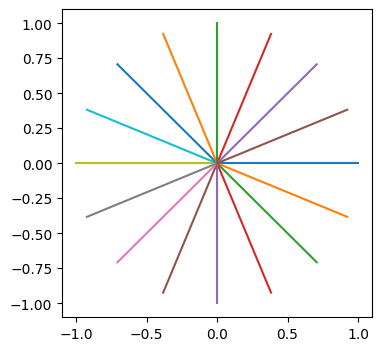

In [41]:
plt.figure(figsize=(4, 4))
for w in pathway_weights:
    plt.plot([0, np.real(w)], [0, np.imag(w)])

plt.show()

In [42]:
sim = Simulator(
    spin_systems=[sys],
    methods=methods,
)
sim.config.integration_density = 120

sim.run()

### Assert the simulations are scaled by the pathway weights

In [43]:
A = np.abs(sim.methods[0].simulation)

for i, mth in enumerate(sim.methods):
    B = mth.simulation
    re_weight = np.real(pathway_weights[i])
    im_weight = np.imag(pathway_weights[i])

    assert B.real == A * re_weight
    assert B.imag == A * im_weight

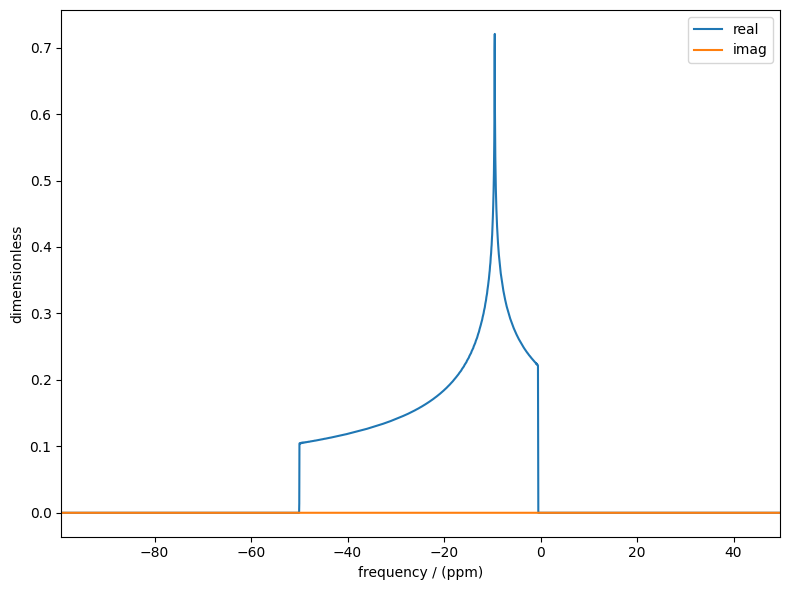

In [44]:
plt.figure(figsize=(8, 6))
ax = plt.subplot(projection="csdm")
ax.plot(sim.methods[0].simulation.real, color="tab:blue", label="real")
ax.plot(sim.methods[0].simulation.imag, color="tab:orange", label="imag")
plt.legend()
plt.tight_layout()
plt.show()

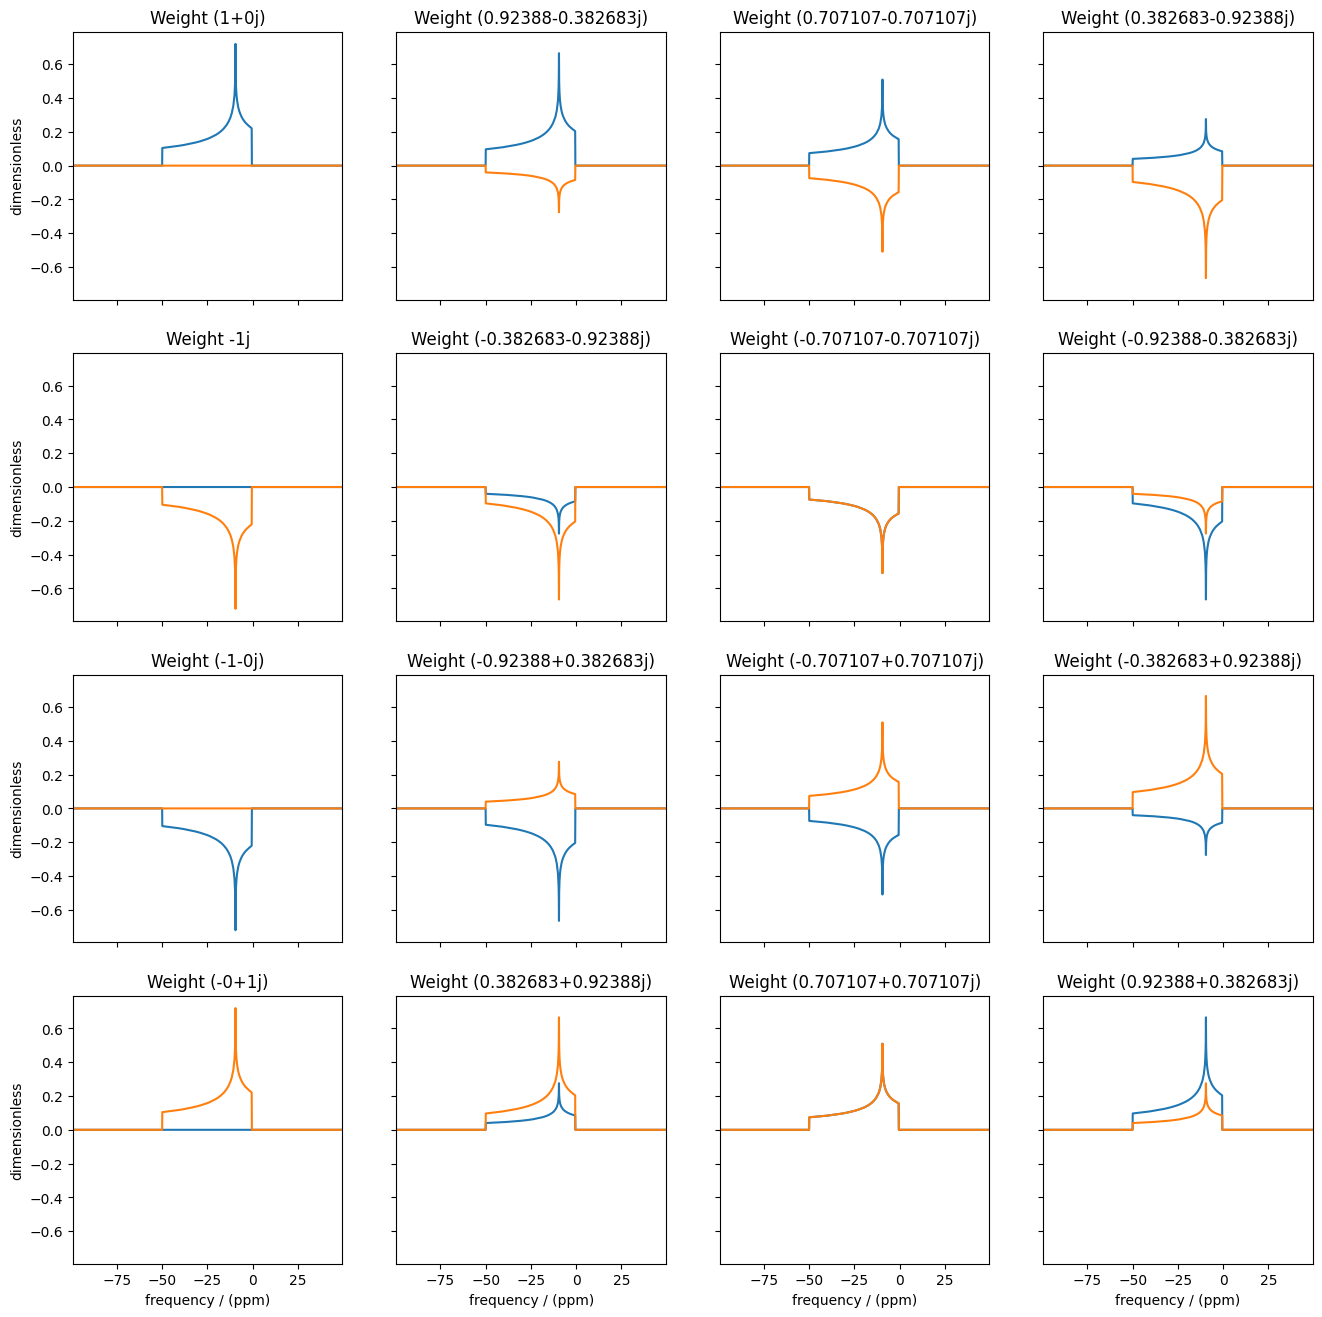

In [45]:
fig, ax = plt.subplots(4, 4, figsize=(16, 16), sharex=True, sharey=True, subplot_kw={"projection": "csdm"})

for i, mth in enumerate(sim.methods):
    row = i // 4
    col = i % 4

    ax[row, col].plot(mth.simulation.real, color="tab:blue", label="real")
    ax[row, col].plot(mth.simulation.imag, color="tab:orange", label="imag")
    ax[row, col].set_title(f"Weight {pathway_weights[i]}")
#     ax[row, col].set_title(f"Phase {(np.asarray(pathway_phases) / np.pi).round(3)[i]}")

    # Clear x label on upper plots
    if row != 3:
         ax[row, col].get_xaxis().get_label().set_visible(False)

    # Clear y label on right-hand plots
    if col != 0:
         ax[row, col].get_yaxis().get_label().set_visible(False)


plt.show()